# Open problems 2b

Consider the extended Galactic source RX J1713-3946, located at 1 kpc from us. Its coordinates are l, b = 347.313895°, -0.459872° and its spectrum can be modeled with a powerlaw of $\Gamma=2.06$ and amplitude of $2.3\times10^{-11}$ cm$^{-2}$ s$^{-1}$ TeV$^{-1}$ at 1 TeV.
Simulate it and fit the sampled events to estimate the constraints on the size of its morpholgy. Then, move the source to larger distances, rescaling the powerlaw amplitude and the source size accordingly, and estimate its morphology. Calculate how the constraints on the size change with the distance. For simplicity, consider an exposure time of 10 hours and fix the source coordinates when fitting the model.

In [1]:
import matplotlib.pyplot as plt

from pathlib import Path
import time
import numpy as np
import threading
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.io import fits
from astropy.time import Time
from regions import CircleSkyRegion, PointSkyRegion
from gammapy.data import Observation, observatory_locations, FixedPointingInfo, PointingMode
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import MapDatasetMaker
from gammapy.maps import MapAxis, RegionNDMap, WcsGeom, Map
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ConstantSpectralModel,
    FoVBackgroundModel,
    LightCurveTemplateTemporalModel,
    DiskSpatialModel,
    ConstantTemporalModel,
     PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
    Models
)

Let's simulate the source RX J1713-3946. This is located at 1 kpc of distance, at coordinates l, b = 347.313895°, -0.459872°. Its spectrum can be modeled with a powerlaw of $\Gamma=2.06$ and amplitude of $2.3\times10^{-11}$ cm$^{-2}$ s$^{-1}$ TeV$^{-1}$ at 1 TeV. 

The integrated flux is: 
$F_{1~\text{kpc}} = \int_{0.01~\text{TeV}}^{10~\text{TeV}} N_{1~\text{kpc}} \cdot (\cfrac{E}{E_0})^{-\Gamma} dE$

from which we can estimate the luminosity, which has to be unvariant for the distance:

$L_{\gamma} = F_{1~\text{kpc}} \cdot 4 \cdot \pi \cdot D_{1~\text{kpc}}^2$

$L_{\gamma} = F_D \cdot 4 \cdot \pi \cdot D^2$


Therefore, the powerlaw amplitude $N_D$ scales with the distance as:

$N_D = N_{1~\text{kpc}} \cdot (\cfrac{1~\text{kpc}}{D})^2$


If the source has a disk morphology with radius $r=0.5$° at 1 kpc, its real size is 8.73e-3 kpc. 
The scaling relation with the distance is:

$r = \text{arctan}(0.00873~\text{kpc} / D)$

In [2]:
# let's determine the powerlaw amplitude for the different distances:

distances = [1, 2, 3, 4, 5, 7, 10, 15] * u.kpc
amplitudes = 2.3e-11 * u.cm**-2 * u.s**-1 * u.TeV**-1 * (1 * u.kpc / distances)**2
amplitudes

<Quantity [2.30000000e-11, 5.75000000e-12, 2.55555556e-12, 1.43750000e-12,
           9.20000000e-13, 4.69387755e-13, 2.30000000e-13, 1.02222222e-13] 1 / (TeV s cm2)>

In [3]:
# let's determine the size of the radius for the different distances:
radius = np.arctan(0.00873 * u.kpc / distances).to("deg")
radius

<Quantity [0.50017945, 0.25009449, 0.16673025, 0.12504784, 0.10003833,
           0.07145599, 0.0500192 , 0.03334614] deg>

In [4]:
# create the observation and the dataset

energy_axis = MapAxis.from_energy_bounds("0.01 TeV", "150 TeV",
                                         nbin=5, per_decade=True)
energy_axis_true = MapAxis.from_energy_bounds("0.001 TeV", "250 TeV", 
                                         nbin=10, per_decade=True, 
                                         name="energy_true")

In [5]:
# let's fix the source coordinates and the pointing direction:

target = SkyCoord("347.313895 deg", "-0.459872 deg", unit="deg", frame="galactic")

pointing = target.directional_offset_by(position_angle = 0 * u.deg, separation = 0.5 * u.deg)

In [6]:
# let's load the IRF:

path = "$GAMMAPY_DATA/cta-caldb/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz"
irf = load_irf_dict_from_file(path)

In [7]:
# let's the define the geometry:

geom = WcsGeom.create(
            skydir=pointing,
            width=(2.5, 2.5), #deg
            binsz=0.02, #deg
            frame="icrs",
            axes=[energy_axis],
            )

empty = MapDataset.create(
            geom,
            energy_axis_true=energy_axis_true,
            name="my-dataset",
            )

In [8]:
# let's create the observation object:

time_ref = Time("2024-06-25T00:00:00", format="isot", scale="utc")

livetime = 10 * u.hr

print(f"Simulation for exposure: {livetime}")
observation = Observation.create(
                obs_id="0001",
                pointing=pointing,
                livetime=livetime,
                irfs=irf,
                reference_time=time_ref,
                )
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
dataset = maker.run(empty, observation)

Simulation for exposure: 10.0 h


/home/feijen/anaconda3/envs/gammapy-1.2-withray/lib/python3.10/site-packages/gammapy/data/observations.py:281: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


In [9]:
# let's create the bkg model 

bkg = FoVBackgroundModel(dataset_name="my-dataset")

In [10]:
# Let's loop over the different distances, i.e. different amplitudes.
# For each, we fit the simulated events and estimate the sigma and its uncertainty.

sigmas, errors = [], []
for N, r, dist in zip(amplitudes, radius, distances):
    print(f"Calculation for a distance of {dist}")

    spatial_model = model = DiskSpatialModel(
                            lon_0=target.l.deg * u.deg,
                            lat_0=target.b.deg * u.deg,
                            r_0=r,
                            frame="galactic",
                            )

    spectral_model = PowerLawSpectralModel(index=2.06, amplitude=N, reference="1 TeV")
    
    source_model = SkyModel(spectral_model = spectral_model,
                           spatial_model = spatial_model,
                           name = "fake_src")
    
    full_model = Models([source_model, bkg])
    
    #  Note here we do not need to use 'copy' as we are redefining the model at each step in the loop
    dataset.models = full_model

# if you want to perform the simulation with MapDatasetEventSampler
# First you must add the 'migra_axis' to the MapDataset.create
# set a migra axis only if you want simulate DL3 events
# migra_axis = MapAxis.from_bounds(0.5, 2, nbin=150, node_type="edges", name="migra")
# 
#    sampler = MapDatasetEventSampler(random_state=0)
#    events = sampler.run(dataset, observation)
#    counts = Map.from_geom(geom)
#    counts.fill_events(events)
#    dataset.counts = counts

    dataset.fake()
    
    dataset.models.parameters["lon_0"].frozen = True
    dataset.models.parameters["lat_0"].frozen = True

    fit = Fit()
    minuit_opts = {"strategy": 2}
    fit.backend = "minuit"
    fit.optimize_opts = minuit_opts
    result = fit.run(dataset)
    sigmas.append(result.models[0].spatial_model.r_0.value)
    errors.append(result.models[0].spatial_model.r_0.error)
    print(result)

Calculation for a distance of 1.0 kpc
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 110
	total stat : -1516930.91

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Calculation for a distance of 2.0 kpc
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 124
	total stat : -1457346.90

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Calculation for a distance of 3.0 kpc
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 167
	total stat : -1446704.66

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated success

Let's plot our results as a function of the distance:

Text(0.5, 1.0, 'Constrain on the source extension')

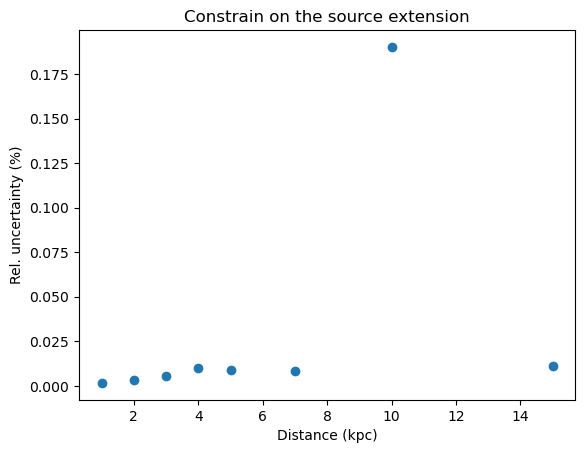

In [11]:
plt.plot(distances, np.array(errors) / np.array(sigmas), "o")
#plt.loglog()
plt.xlabel("Distance (kpc)")
plt.ylabel("Rel. uncertainty (%)")
plt.title("Constrain on the source extension")